In [9]:
import jax
import jax.numpy as jnp
import jax.scipy.linalg as linalg
from jax import grad, value_and_grad, lax
import matplotlib.pyplot as plt
import optax
import jax.random as random
from functools import partial

In [10]:
jax.config.update("jax_enable_x64", True)

In [107]:
def get_problems( _x, _y, _t, prob='exp_t'):
    X, Y = jnp.meshgrid(_x[1:-1], _y[1:-1], indexing='ij')
    _t_trunc = _t[1:][:, None, None]
    _x_trunc = _x[1:-1][None, :, None]
    _y_trunc = _y[1:-1][None, None, :]

    if prob == 'exp_t':
      u0_true = jnp.sin(jnp.pi * X) * jnp.sin(jnp.pi * Y)
      term1 = (1 - 2 * _t_trunc + 2 * jnp.pi**2) * jnp.exp(_t_trunc**2)
      term2 = jnp.exp(-2*_t_trunc**2 + _t_trunc) * jnp.sin(jnp.pi * _x_trunc) * jnp.sin(jnp.pi * _y_trunc)
      f_true = term1 * term2

    elif prob == 'cossinsin':
      u0_true = jnp.sin(5*jnp.pi * X) * jnp.sin(5*jnp.pi * Y)
      term1 = 5* jnp.pi * jnp.sin(5*jnp.pi * _x_trunc) * jnp.sin(5*jnp.pi * _y_trunc)
      term2 = 10*jnp.pi*jnp.cos(5*jnp.pi*_t_trunc) - jnp.sin(5* jnp.pi * _t_trunc)
      f_true = term1 * term2

    return u0_true, f_true


In [108]:
def heat_solver_matrix_2d(n_x, n_y):
    """Create the 2D heat equation matrix using Kronecker products for efficiency"""
    h_x = 1.0 / (n_x - 1)
    h_y = 1.0 / (n_y - 1)

    # 1D Laplacian matrices
    # For x-direction
    n_inner_x = n_x - 2
    diag_x = jnp.ones(n_inner_x) * 2.0 / (h_x**2)
    off_diag_x = jnp.ones(n_inner_x - 1) * (-1.0 / (h_x**2))
    A_x = jnp.diag(diag_x) + jnp.diag(off_diag_x, 1) + jnp.diag(off_diag_x, -1)

    # For y-direction
    n_inner_y = n_y - 2
    diag_y = jnp.ones(n_inner_y) * 2.0 / (h_y**2)
    off_diag_y = jnp.ones(n_inner_y - 1) * (-1.0 / (h_y**2))
    A_y = jnp.diag(diag_y) + jnp.diag(off_diag_y, 1) + jnp.diag(off_diag_y, -1)

    # 2D Laplacian using Kronecker product: A = I_y ⊗ A_x + A_y ⊗ I_x
    I_x = jnp.eye(n_inner_x)
    I_y = jnp.eye(n_inner_y)
    A_2d = jnp.kron(I_y, A_x) + jnp.kron(A_y, I_x)

    return A_2d

In [109]:
@jax.jit
def crank_nicolson_step(u, f_n, f_n1, A, k):
    """
    Crank-Nicolson step for 2D heat equation
    (I + k/2 * A) u_{n+1} = (I - k/2 * A) u_n + k/2 * (f_n + f_{n+1})
    """
    n = u.shape[0]
    I = jnp.eye(n)

    # Left-hand side matrix
    lhs_matrix = I + (k/2) * A

    # Right-hand side
    rhs = (I - (k/2) * A) @ u + (k/2) * (f_n + f_n1)

    L = jnp.linalg.cholesky(lhs_matrix)
    y = jax.scipy.linalg.solve_triangular(L, rhs, lower=True)
    u_next = jax.scipy.linalg.solve_triangular(L.T, y, lower=False)

    return u_next

In [110]:
@jax.jit
def time_stepping_2d(u0, f, A, k, x, y, t, n_x, n_y):
    """Time stepping using Crank-Nicolson for 2D heat equation"""
    n_inner_x = n_x - 1
    n_inner_y = n_y - 1
    n_dof = n_inner_x * n_inner_y

    u0 = u0.reshape(-1)  # Flatten initial condition

    def body_fn(u_prev, carry):
      f_n, f_n1 = carry
      u_next = crank_nicolson_step(u_prev, f_n.flatten(), f_n1.flatten(), A, k)
      return u_next, u_next

    _, us = jax.lax.scan(body_fn, u0, (f[:-1], f[1:]))
    return jnp.vstack([u0[None, :], us])

In [111]:
@jax.jit
def loss_fn(f, u0_true, u_traj_true, A, k, x, y, t, n_x, n_y):
    """Loss function for 2D heat equation"""
    # Time stepping with learned forcing
    u_traj_guess = time_stepping_2d(u0_true, f, A, k, x, y, t, n_x, n_y)

    # MSE loss
    mse = jnp.linalg.norm(u_traj_guess - u_traj_true)

    # L2 regularization on forcing
    reg = jnp.linalg.norm(f)

    # Smoothness regularization (1st order)
    smooth_1st_x = jnp.linalg.norm(f[:, 1:, :] - f[:,:-1, :])
    smooth_1st_y = jnp.linalg.norm(f[:, :, 1:] - f[:, :, :-1])

    # 2nd order smoothness
    smooth_2nd_x = jnp.linalg.norm(f[:, 2:, :] - 2*f[:, 1:-1, :] + f[:, :-2, :])
    smooth_2nd_y = jnp.linalg.norm(f[:, :, 2:] - 2*f[:, :, 1:-1] + f[:, :, :-2])

    # Cross derivative smoothness
    smooth_2nd_xy = jnp.linalg.norm(f[:, 1:, 1:] - f[:, 1:, :-1] - f[:, :-1, 1:] + f[:, :-1, :-1])

    # Time derivative
    smooth_t = jnp.linalg.norm(f[:, :, 1:] - f[:,:, :-1])

    # Regularization parameters
    reg_alpha = 1e-5
    reg_smooth_1st = 1e-3
    reg_smooth_2nd = 1e-3
    reg_smooth_cross = 1e-3
    reg_smooth_t= 1e-3

    total_loss = mse + \
        reg_alpha * reg + \
        reg_smooth_1st * (smooth_1st_x + smooth_1st_y) + \
        reg_smooth_2nd * (smooth_2nd_x + smooth_2nd_y) + \
        reg_smooth_cross * smooth_2nd_xy + \
        reg_smooth_t * smooth_t

    return total_loss

In [118]:
# Grid parameters
n_x = 16
n_y = 16
n_t = 100

h_x = 1.0 / (n_x - 1)
h_y = 1.0 / (n_y - 1)

# Time discretization
t_final = 0.5
k = t_final / n_t

# Create grids
x = jnp.linspace(0, 1, n_x)
y = jnp.linspace(0, 1, n_y)
t = jnp.linspace(0, t_final, n_t + 1)

# Number of interior points
n_inner_x = n_x - 1
n_inner_y = n_y - 1
n_dof = n_inner_x * n_inner_y

# Create system matrix
A = heat_solver_matrix_2d(n_x, n_y)

# Generate true u0 and true f
u0_true, f_true = get_problems(x, y, t, prob='exp_t')

u_traj_true = time_stepping_2d(u0_true, f_true, A, k, x, y, t, n_x, n_y)


In [119]:
print(f"f_true.shape = {f_true.shape}")
print(f"u0_true.shape = {u0_true.shape}")
print(f"u_traj_true.shape = {u_traj_true.shape}")
print(f"A.shape = {A.shape}")


f_true.shape = (100, 14, 14)
u0_true.shape = (14, 14)
u_traj_true.shape = (100, 196)
A.shape = (196, 196)


In [120]:
def train_ada_2d(num_epochs=15000, lr=20):
    """Training loop for 2D heat equation"""

    # Initialize forcing guess
    key = random.PRNGKey(0)
    f_guess = random.normal(key, shape=f_true.shape)

    # Setup optimizer
    opt = optax.adagrad(lr)
    opt_state = opt.init(f_guess)

    losses = []

    # Create partial loss function
    loss_partial = partial(loss_fn,
                           u0_true=u0_true,
                           u_traj_true=u_traj_true,
                           A=A, k=k,
                           x=x, y=y, t=t,
                           n_x=n_x, n_y=n_y)

    print("Starting training...")
    for epoch in range(num_epochs):
        loss, grad = value_and_grad(loss_partial)(f_guess)

        # Update step
        updates, opt_state = opt.update(grad, opt_state)
        f_guess = optax.apply_updates(f_guess, updates)

        losses.append(float(loss))

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss = {loss:.9f}")

    return f_guess, losses

In [121]:
f_learned, losses = train_ada_2d(num_epochs=10000, lr=10)

Starting training...
Epoch 0, Loss = 85.509665009
Epoch 500, Loss = 48.663370374
Epoch 1000, Loss = 15.493440001
Epoch 1500, Loss = 2.567908171
Epoch 2000, Loss = 1.584774693
Epoch 2500, Loss = 1.377952458
Epoch 3000, Loss = 1.302998800
Epoch 3500, Loss = 1.265850364
Epoch 4000, Loss = 1.244833053
Epoch 4500, Loss = 1.232057502
Epoch 5000, Loss = 1.223848837
Epoch 5500, Loss = 1.218327474
Epoch 6000, Loss = 1.220515027
Epoch 6500, Loss = 1.220652497
Epoch 7000, Loss = 1.220756326
Epoch 7500, Loss = 1.220834762
Epoch 8000, Loss = 1.220895261
Epoch 8500, Loss = 1.220942477
Epoch 9000, Loss = 1.220979561
Epoch 9500, Loss = 1.221008751


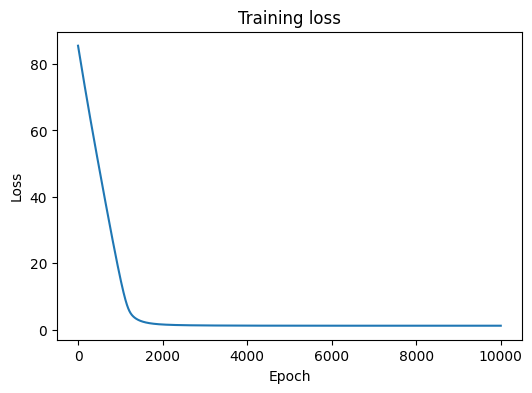

In [122]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

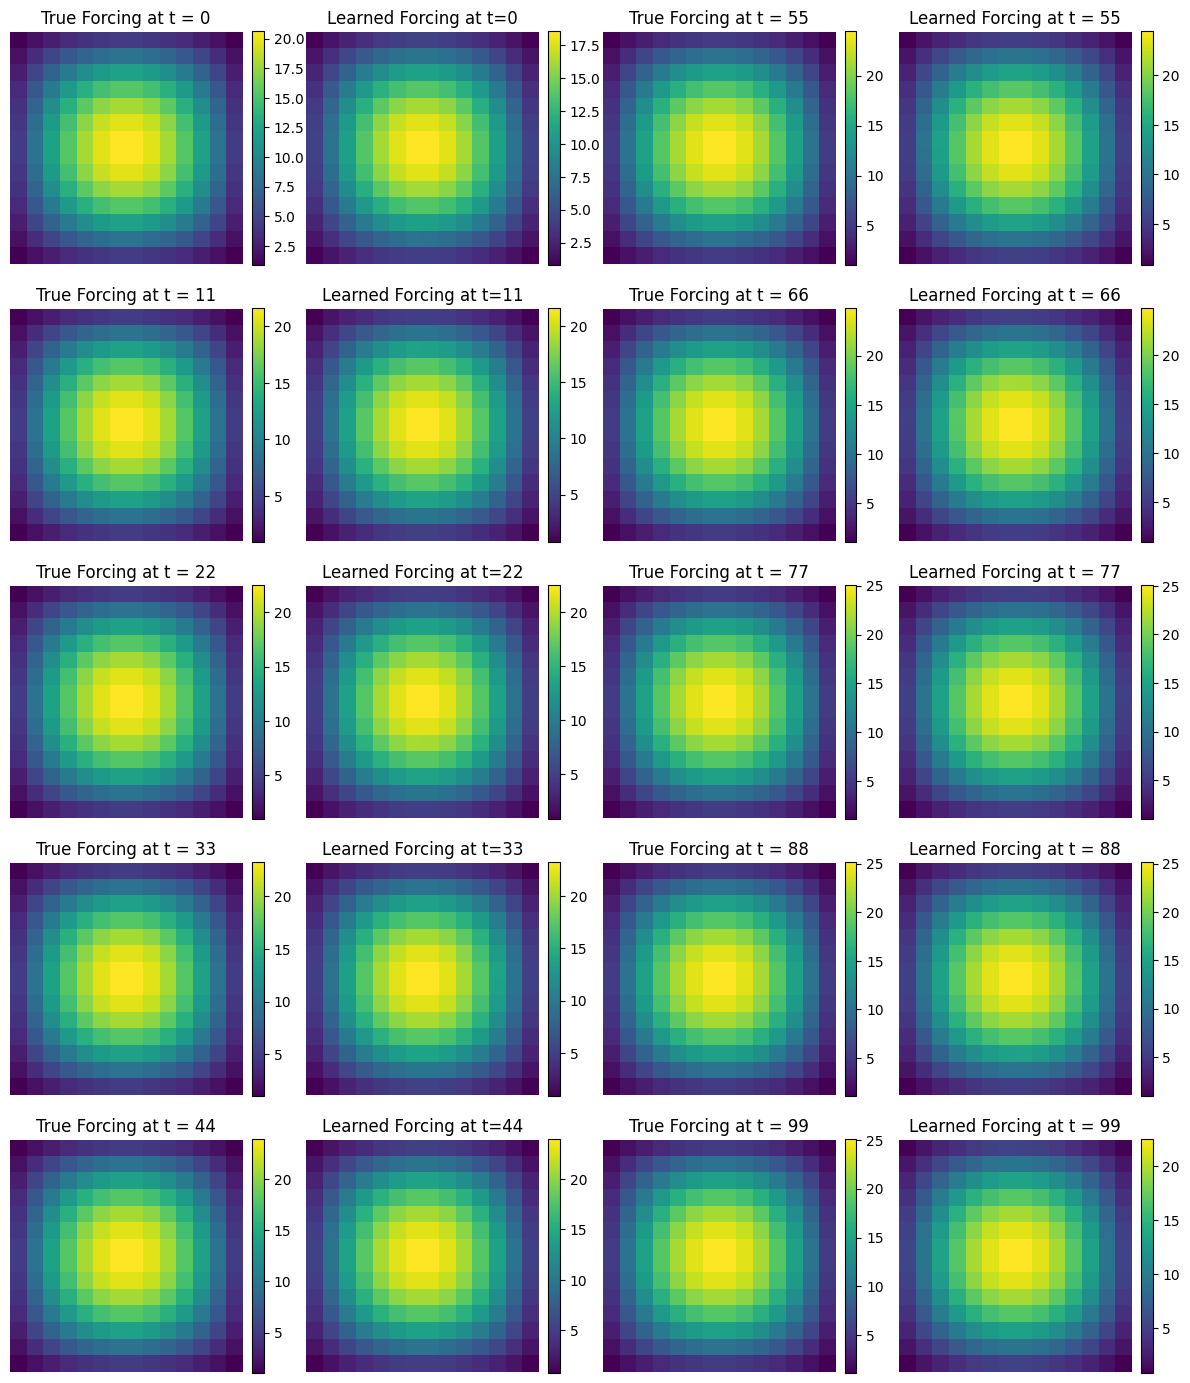

In [123]:
n_t = u_traj_true.shape[0]

# Pick time indices
time_indices = jnp.linspace(0, n_t - 1, 10, dtype=int)
half = 5

fig, axes = plt.subplots(half, 4, figsize=(12, 2.8 * half))
for i in range(half):
    # Left half
    t_idx_left = time_indices[i]
    im1 = axes[i, 0].imshow(f_true[t_idx_left], cmap='viridis', origin='lower')
    axes[i, 0].set_title(f"True Forcing at t = {t_idx_left}")
    axes[i, 0].axis('off')
    fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

    im2 = axes[i, 1].imshow(f_learned[t_idx_left], cmap='viridis', origin='lower')
    axes[i, 1].set_title(f"Learned Forcing at t={t_idx_left}")
    axes[i, 1].axis('off')
    fig.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Right half
    t_idx_right = time_indices[i + half]
    im3 = axes[i, 2].imshow(f_true[t_idx_right], cmap='viridis', origin='lower')
    axes[i, 2].set_title(f"True Forcing at t = {t_idx_right}")
    axes[i, 2].axis('off')
    fig.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

    im4 = axes[i, 3].imshow(f_learned[t_idx_right], cmap='viridis', origin='lower')
    axes[i, 3].set_title(f"Learned Forcing at t = {t_idx_right}")
    axes[i, 3].axis('off')
    fig.colorbar(im4, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

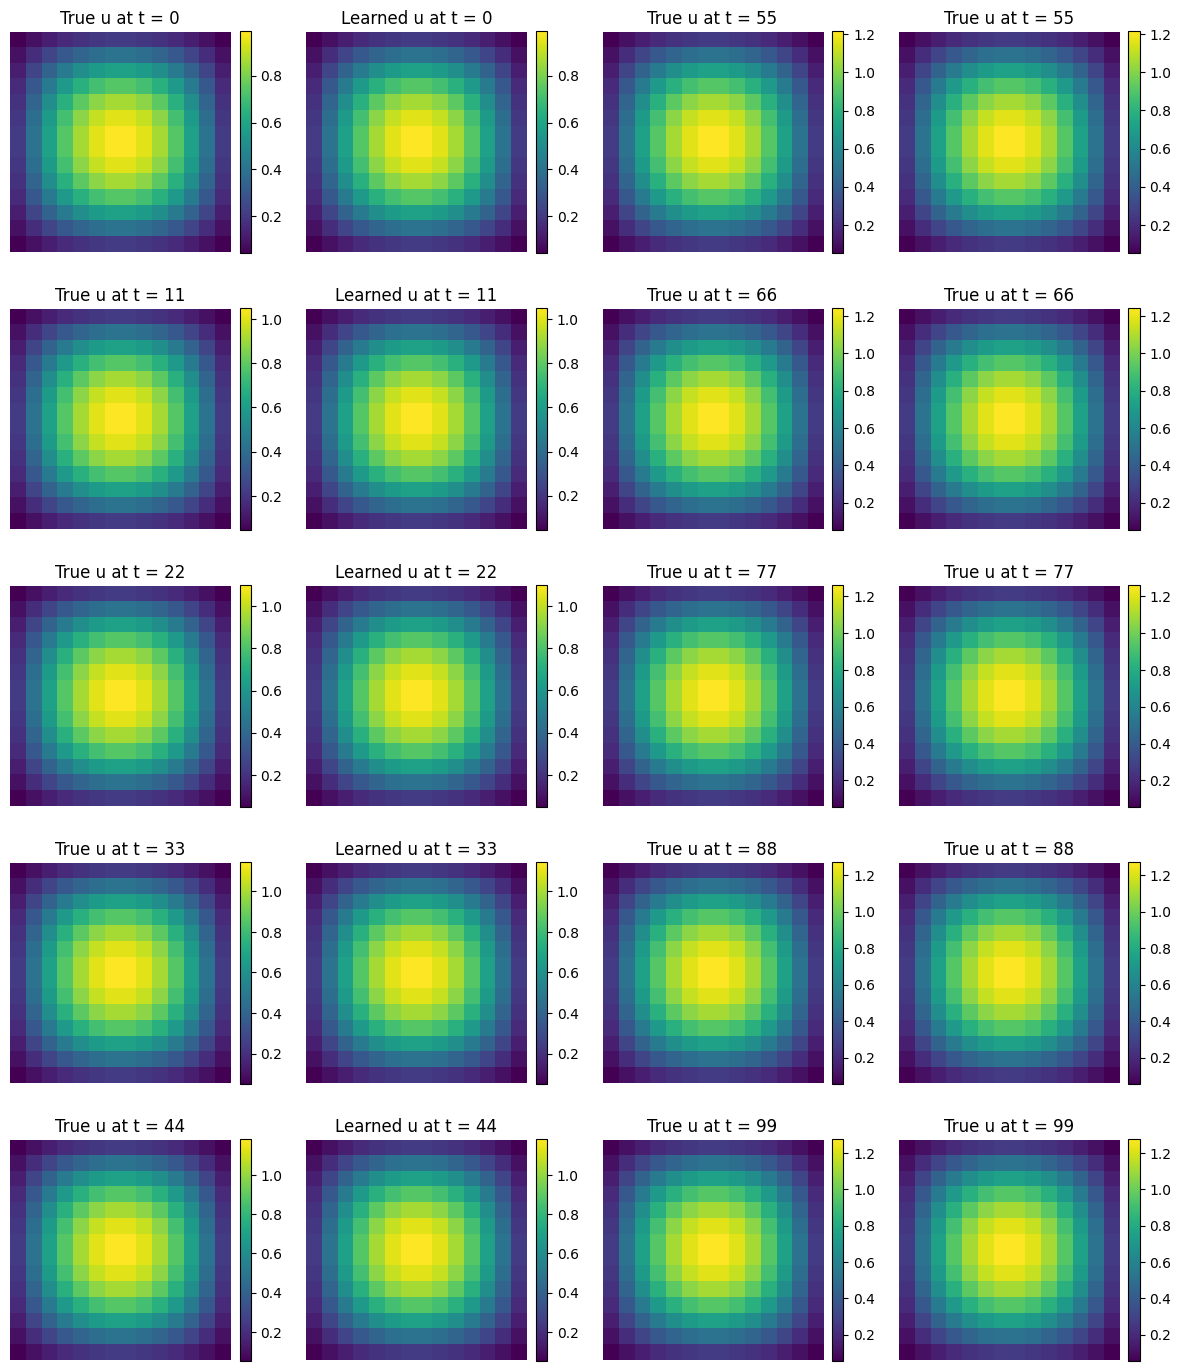

In [124]:
u_true = u_traj_true.reshape(-1, n_x - 2, n_y - 2)
u_learned = time_stepping_2d(u0_true, f_learned, A, k, x, y, t, n_x, n_y).reshape(-1, n_x - 2, n_y - 2)
n_t = u_true.shape[0]

# Pick time indices
time_indices = jnp.linspace(0, n_t - 1, 10, dtype=int)
half = 5

fig, axes = plt.subplots(half, 4, figsize=(12, 2.8 * half))

for i in range(half):
    # Left half
    t_idx_left = time_indices[i]
    im1 = axes[i, 0].imshow(u_true[t_idx_left], cmap='viridis', origin='lower')
    axes[i, 0].set_title(f"True u at t = {t_idx_left}")
    axes[i, 0].axis('off')
    fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

    im2 = axes[i, 1].imshow(u_learned[t_idx_left], cmap='viridis', origin='lower')
    axes[i, 1].set_title(f"Learned u at t = {t_idx_left}")
    axes[i, 1].axis('off')
    fig.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Right half
    t_idx_right = time_indices[i + half]
    im3 = axes[i, 2].imshow(u_true[t_idx_right], cmap='viridis', origin='lower')
    axes[i, 2].set_title(f"True u at t = {t_idx_right}")
    axes[i, 2].axis('off')
    fig.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

    im4 = axes[i, 3].imshow(u_learned[t_idx_right], cmap='viridis', origin='lower')
    axes[i, 3].set_title(f"True u at t = {t_idx_right}")
    axes[i, 3].axis('off')
    fig.colorbar(im4, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()